In [1]:
import numpy as np
import scipy.stats as ss
import elfi

In [2]:
def fun(x, batch_size, random_state):
    return np.sum(x, keepdims=True, axis=1)

In [31]:
t1 = elfi.Prior(ss.multivariate_normal, [0, 0, 0, 1])
sim = elfi.Simulator(fun, t1, observed=np.array([[0]]))
d = elfi.Distance('euclidean', sim)

ValueError: x and y must be the same size

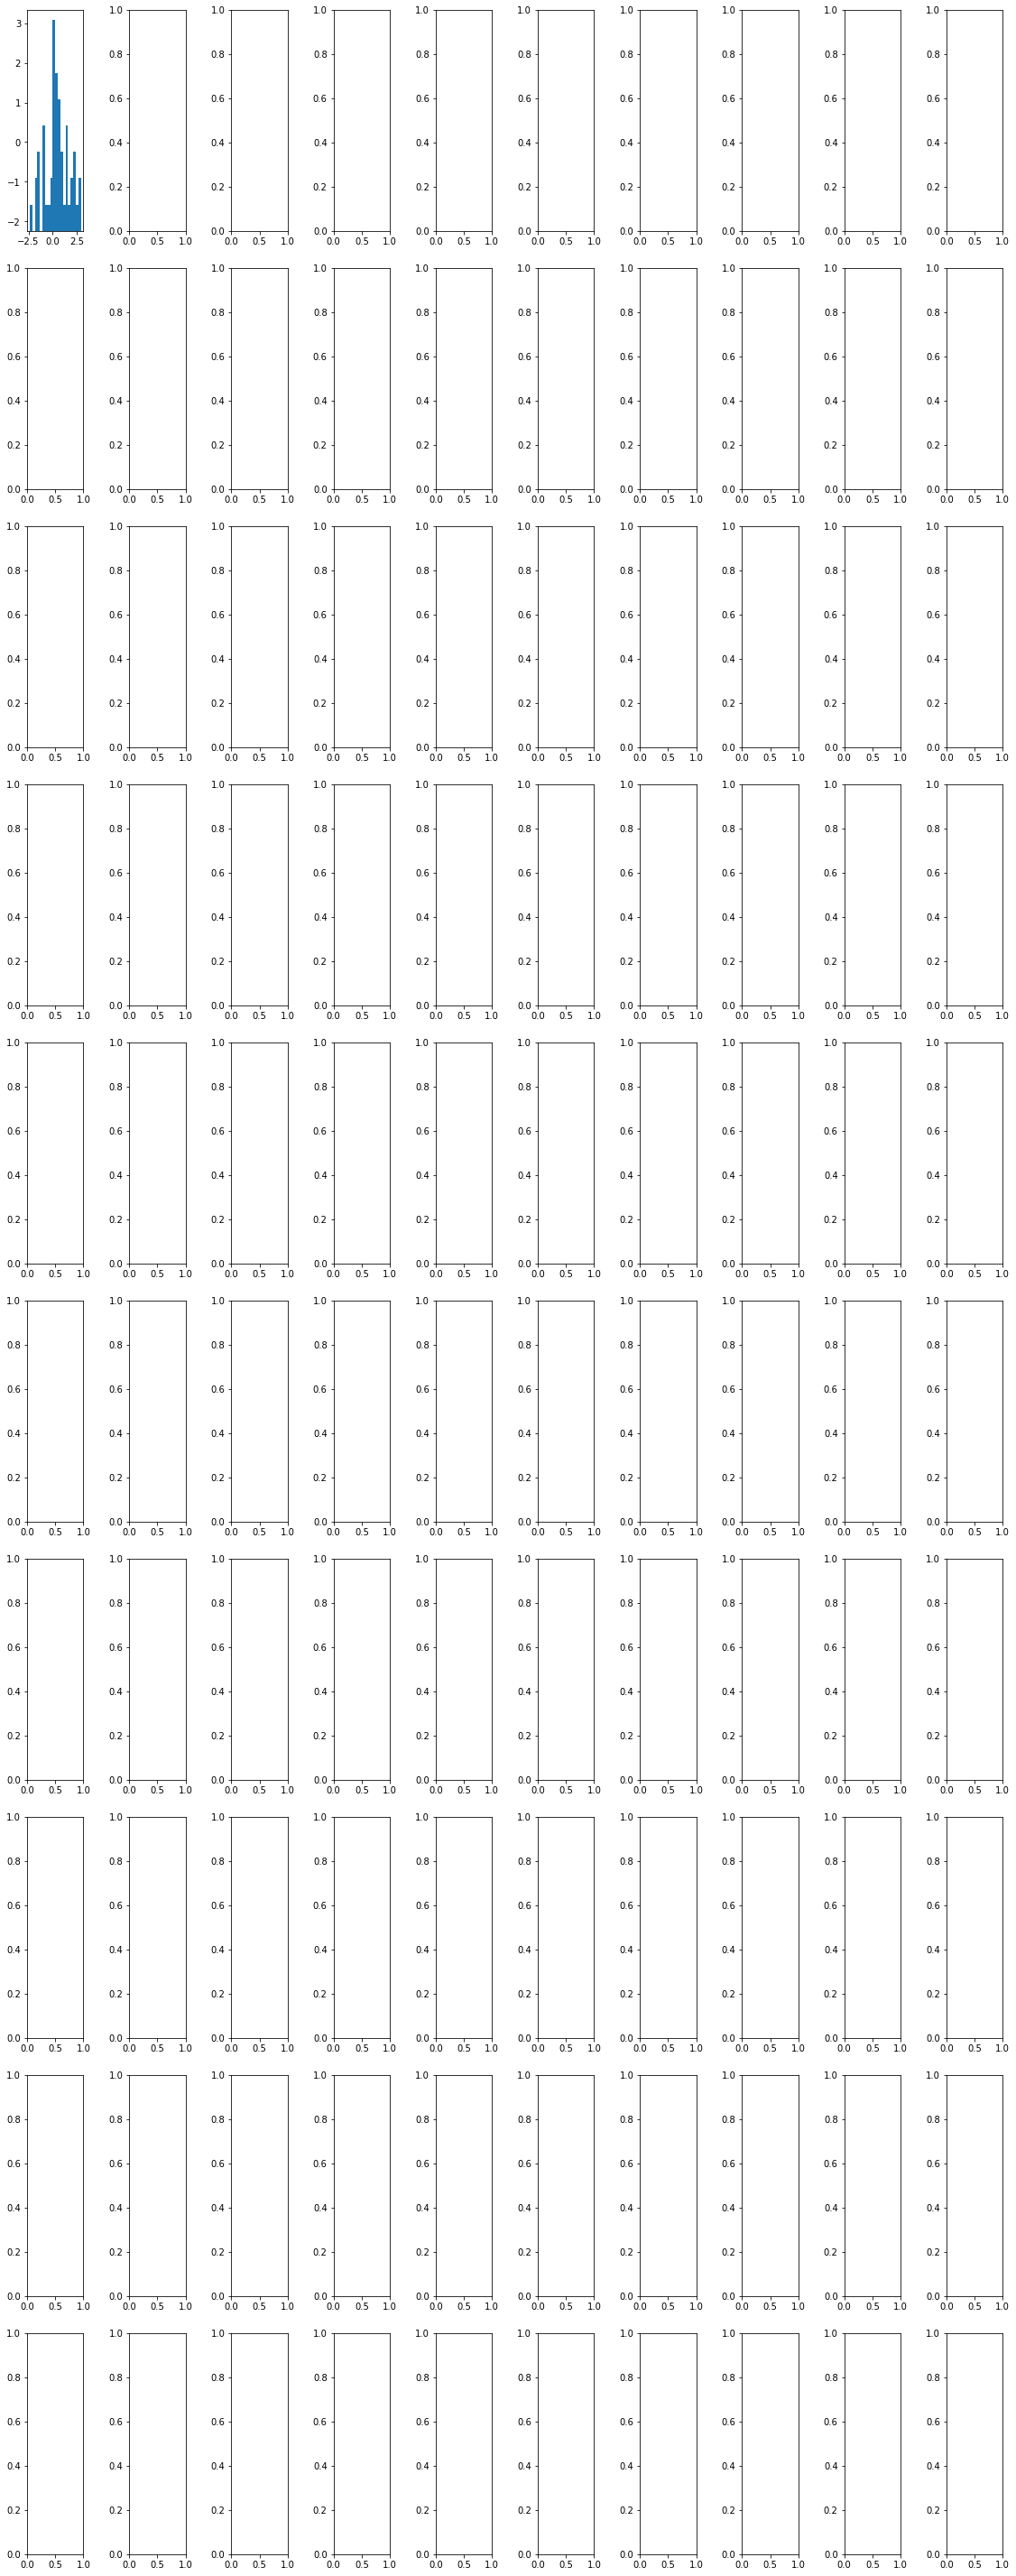

In [32]:
elfi.Rejection(sim, batch_size=10).sample(10).plot_pairs()